In [1]:
# Импортируем основные модули pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Импортируем модули, связанные с компьютерным зрением
from torchvision import datasets
import torchvision.transforms as T  # пакет transforms будет доступен под именем T
from torchvision.models import vgg16  # импортируем модель AlexNet

# Импортируем вспомогательные модули
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# В данной лабораторной работе предлагается дообучить предобученные модели на уже известном нам наборе CIFAR10.
# В этой части предлагается поработать с архитектурой AlexNet.
# Необходимо:
# 1. Подготовить изображения (см. ниже);
# 2. "Заморозить" веса предобученной модели;
# 3. Заменить последний слой для соответствия размерности выхода 10-яти классам;
# 4. Дообучить модель.

In [2]:
# Последовательность преобразований исходных изображений. Нужно заполнить.
# Смысл этих преобразований в том, чтобы привести входные изображения из набора CIFAR10 к тому виду, который был у
# изображений из набора, на котором была предобучена сеть. А именно:
# 1. Картинки 3-ех канальные с размером 224 х 224 пикселей.
# 2. Картики должны быть преобразованы в тензор и иметь цветовые компоненты на отрезке [0; 1].
# 3. Среднее по цветовым каналам должно быть [0.485, 0.456, 0.406], а среднеквадратическое отклонение [0.229, 0.224, 0.225].
# Посмотрите документацию по классам Compose, Resize, CenterCrop, ToTensor, Normalize из пакета torchvision.transforms.
transforms = T.Compose([
    # ВАШ КОД ЗДЕСЬ
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    # ===============
])

# Задаем количество эпох (проходов по всей обучающей выборке) и размер пакета, можно варьировать
EPOCHS = 3
BATCH_SIZE = 128

# Загружаем данные из набора CIFAR10
train_data = datasets.CIFAR10(root='./data/train', train=True, download=True, transform=transforms)
test_data = datasets.CIFAR10(root='./data/test', train=False, download=True, transform=transforms)

# DataLoader позволяет разбить выборку на пакеты заданного размера.
# Параметр shuffle отвечает за перемешивание данных в пакете
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Если графический ускоритель поддерживает обучение на нем, будем использовать его,
# иначе обучать на процессоре.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = vgg16(pretrained=True)  # загружаем модель с предобученными весами
# Здесь необходимо выполнить 2-ой и 3-ий пункты.
# ВАШ КОД ЗДЕСЬ
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(in_features=4096, out_features=10)
# ===============

# Готовимся к обучению
model = model.to(device)  # переносим модель на доступное устройство
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()))  # оптимизатор, нужно выбрать и настроить
loss_function = nn.CrossEntropyLoss()  # функция потерь, нужно выбрать
loss_history = list()  # список для хранения истории изменения функции стоимости

In [4]:
from tqdm import tqdm

391it [03:48,  1.71it/s]
0it [00:00, ?it/s]

Эпоха 1 завершилась с функцией стоимости на последнем пакете = 0.5529666543006897


391it [03:25,  1.91it/s]
0it [00:00, ?it/s]

Эпоха 2 завершилась с функцией стоимости на последнем пакете = 0.48206958174705505


391it [03:21,  1.94it/s]

Эпоха 3 завершилась с функцией стоимости на последнем пакете = 0.8148854970932007


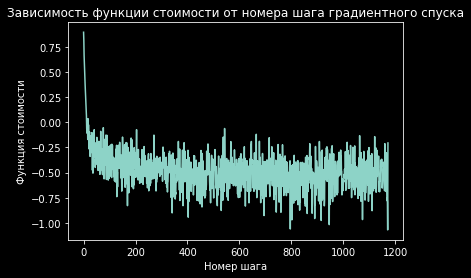

In [5]:
# Начинаем обучение
for epoch in range(EPOCHS):
    for i, (batch, labels) in tqdm(enumerate(train_loader)):  # разбиваем выборку на пакеты
        # Нужно реализовать один шаг градиентного спуска
        # loss = torch.tensor(0, dtype=torch.float32)  # значение функции стоимости на пакете, нужно рассчитать
        # ВАШ КОД ЗДЕСЬ
        model.zero_grad()
        outputs = model(batch.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        # ===============
        loss_history.append(loss.log().item())  # добавляется логарифм стоимости для большей наглядности
    print(f'Эпоха {epoch + 1} завершилась с функцией стоимости на последнем пакете = {loss.item()}')


# Выводим график функции стоимости
plt.title('Зависимость функции стоимости от номера шага градиентного спуска')
plt.xlabel('Номер шага')
plt.ylabel('Функция стоимости')
plt.plot(loss_history)
plt.show()

In [6]:
# Отключаем расчет вычислительного графа для экономии времени и памяти: нам не нужно считать градиенты при тестировании модели
with torch.no_grad():
    # Оцениваем качество модели
    train_data_loader = DataLoader(train_data, batch_size=128)
    train_features, train_targets = next(iter(train_data_loader))

    train_features = train_features.to(device)
    train_model_predictions = torch.argmax(model(train_features), dim=1)
    print('Точность (accuracy) на обучающей выборке:', accuracy_score(train_targets, train_model_predictions.cpu()))

    test_data_loader = DataLoader(test_data, batch_size=128)
    test_features, test_targets = next(iter(test_data_loader))

    test_features = test_features.to(device)
    test_model_predictions = torch.argmax(model(test_features), dim=1)
    print('Точность (accuracy) на тестовой выборке:', accuracy_score(test_targets, test_model_predictions.cpu()))

Точность (accuracy) на обучающей выборке: 0.8359375
Точность (accuracy) на тестовой выборке: 0.78125
